# Sentiment Classification of US Airline Tweets <a name="top"></a>

The goal of this notebook is to apply a supervised/semi-supervised [ULMFiT](https://arxiv.org/abs/1801.06146) model to Twitter US Airlines Sentiment data.

In particular, I have chosen to focus on the sentiment classification task. We could instead investigate other subjects, such as classifying the negative reason or predicting whether a tweet will be retweeted, however many of these analyses take a similar form so I will limit my discussion of other models to the data exploration section.

At a high level, after preparing the notebook and exploring the data, we fine-tune [fastai](https://www.fast.ai/about/)'s general [WikiText-103 language model](http://files.fast.ai/models/wt103/) on the tweet data. Then we transfer the fine-tuned word embedding layer (i.e. encoder) to a new language classification model which we train to predict whether the tweet expresses a *negative*, *neutral*, or *positive* sentiment. Finally, we check our work, investigate sources of error, and propose potential next steps to take for improving the model further.

A baseline model for this task, which always predicts *negative* (the most common class), has an accuracy of 62.69%. The best two results I found in an online search for public sentiment classification models on this dataset are:
* [jiashenliu 2017](https://www.kaggle.com/jiashenliu/how-can-we-predict-the-sentiment-by-tweets) - a random forest with 81.3% accuracy
* [Stanford 2016](http://cs229.stanford.edu/proj2016spr/report/042.pdf) - an SVM (linear kernel) with 80% accuracy

After training, our best model has a final test accuracy of **82.5%. **TODO: comment further** .

To streamline this notebook, I've commented out some sections which list many lines of output. Wherever this is done, I've written about my observations immediately below.

## Notebook Contents:
0. [Notebook Setup](#0)
0. [Load, Analyze, and Prepare the Data](#1)
   1. sentiment label exploration: [airline_sentiment](#airline_sentiment)
   1. negative reason labels exploration: [negativereason](#negativereason)
   1. language data exploration: [text](#text)
   1. location data exploration: [tweet_coord, tweet_location, user_timezone](#tweet_coord)
   1. time data exploration: [tweet_created, user_timezone](#tweet_created)
   1. other data exploration: [retweet_count](#retweet_count)
   1. prepare the [training, validation, and test sets](#prepare-datasets)
0. [Language Model Fine-Tuning](#2)
0. [Classification Model Training](#3)
0. [Analysis and Discussion](#4)

## 0. Notebook Setup 
<a name="0">[(... back to the top)](#top)</a> 

Prepare the the notebook to be restarted from any major section (1, 2, 3, or 4). **Always run this cell:**

In [1]:
# reloads modules without having to restart the kernel
%reload_ext autoreload
%autoreload 2

# automatically displays plots
%matplotlib inline

from fastai.text import *     # implementation of ULMFiT in PyTorch + other NLP tools
import pytz                   # handle timezones
from datetime import datetime # handle dates
from pprint import pprint     # nicely formatted printing

# prefix given to filenames for keeping track of various trials
trial_name = ''

# project path
path = Path('data/twitter-us-airline-sentiment/')
path.mkdir(exist_ok=True)

# columns used in classification tasks (the first column must be the label)
model_input_cols = ['text_len', 'retweet_count', 'tweet_createdLocalHour', 'text']
cols = ['airline_sentiment'] + model_input_cols

## 1. Load, Analyze, and Prepare the Data <a name="1"></a>
<a name="0">[(... back to the top)](#top)</a> 

First, a bit of context. This data was compiled during one week in February 2015 from public tweets that mention any of the following 6 US airlines: American, Delta, Southwest, United, US Airways, and Virgin America.

To get started, download the Twitter US Airline Sentiment data `Tweets.csv` from [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) and put it in your `path` directory.

Load it into pandas to start exploring:

In [2]:
df_raw = pd.read_csv(path / 'Tweets.csv')
print('N Rows:', len(df_raw))

N Rows: 14640


Let's look at a few rows of data to learn what information this dataset contains.

In [3]:
df_raw.iloc[:4]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)


We can now begin classifying our columns:
* natural language: 
  * 'text'
* prediction targets: 
  * 'airline_sentiment', 'negativereason'
* loss importance / confidence in the labels:
  * 'airline_sentiment_confidence', 'negativereason_confidence'
* user location: 
  * 'tweet_coord', 'tweet_location', 'user_timezone'
* time:
  * 'tweet_created'
* numeric data: 
  * 'retweet_count'
* unclear: 
  * 'airline_sentiment_gold', 'negativereason_gold'
* irrelevant to future predictions:
  * 'tweet_id', 'name', 'airline'
  
Most importantly, we need to make sure our language data and prediction targets are clean. The location and additional data columns warrant further investigation as they may be able to add additional predictive power to a model. The 'airline' column is listed as irrelevant because the tweets mention the airlines directly in the text.

Let's start by looking at our labels.

In [4]:
df_raw[['airline_sentiment', 'negativereason']].describe()

,airline_sentiment,negativereason
count,14640,9178
unique,3,10
top,negative,Customer Service Issue
freq,9178,2910


In [5]:
len(df_raw[(df_raw.airline_sentiment == 'negative') & (df_raw.negativereason.notnull())])

9178

Here we see that all rows have sentiment and negative reasons only apply to negative sentiment labels.

Let's take a closer look at our sentiment classification labels. <a name="airline_sentiment" />

In [6]:
def unique_cat_stats(df, colname):
    """For a categorical column, return the unique values as counts and as a percent of total rows."""
    series = df.groupby(colname).count().text
    res = pd.concat([series, series / len(df) * 100], axis=1)
    res.columns = ['raw counts', '% of rows']
    return res

In [7]:
unique_cat_stats(df_raw, 'airline_sentiment')

,raw counts,% of rows
airline_sentiment,,
negative,9178,62.691257
neutral,3099,21.168033
positive,2363,16.140710


We see here that there are 3 classes of airline sentiment, cleanly labeled. Now let's take a look at the 'airline_sentiment_confidence'. <a name="airline_sentiment_confidence" />

min: 0.335 max: 1.0


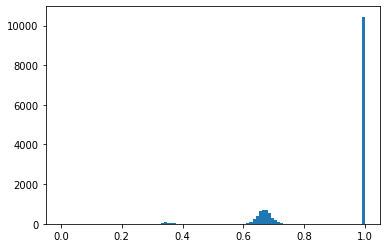

In [8]:
print('min:', df_raw.airline_sentiment_confidence.min(), 'max:', df_raw.airline_sentiment_confidence.max())
plt.hist(df_raw.airline_sentiment_confidence, bins=np.linspace(0,1,101));

In [9]:
low_confidence  = df_raw[df_raw.airline_sentiment_confidence < 0.5]
med_confidence  = df_raw[(0.5 < df_raw.airline_sentiment_confidence) & (df_raw.airline_sentiment_confidence < 0.8)]
high_confidence = df_raw[0.8 < df_raw.airline_sentiment_confidence]
print('n_low_confidence:   ', len(low_confidence), '\nn_med_confidence:  ', len(med_confidence),
      '\nn_high_confidence:', len(high_confidence))
#for r in low_confidence.sample(n=20, random_state=42).iterrows(): print(r[1].airline_sentiment, r[1].text)
#for r in med_confidence.sample(n=20, random_state=42).iterrows(): print(r[1].airline_sentiment, r[1].text)
#for r in high_confidence.sample(n=20, random_state=42).iterrows(): print(r[1].airline_sentiment, r[1].text)

n_low_confidence:    236 
n_med_confidence:   3945 
n_high_confidence: 10459


Three label confidences groups clearly stand out. less than 2% of the labels have a confidence of ~33% and I disagree with the sentiment label on 12 out of 20 randomly selected low confidence labels. With such poor confidence, our predictions would likely be improved by removing these rows from our classification training set. As for the medium confidence labels, which make up about 1/3 of the data, I disagree with 4 out of 20 random labels. It might be helpful to reduce importance of these rows to the training loss. I disagree with 1 out of 20 random high confidence labels.

In [10]:
low_confidence.groupby('airline_sentiment').count().text

airline_sentiment
negative     63
neutral     102
positive     71
Name: text, dtype: int64

Note that by discarding low confidence rows, we would be removing fewer rows with negative sentiment than neutral and positive, thus slightly increasing our bias towards negative rows. This also indicates that it may be slightly harder for humans to correctly classify neutral and positive sentiments compared to negative sentiments.

We now have enough information to describe our sentiment classification task:
- This is a **3-way classification task**, with categories: *negative*, *neutral*, and *positive*.
- This is an unbalanced dataset, biased towards the *negative* class.
- Our naive baseline model, which always predicts *negative*, has an accuracy of 62.69%.

Next, let's take a look at our negative reason classification task. <a name="negativereason" />

In [11]:
unique_cat_stats(df_raw[df_raw.airline_sentiment == 'negative'], 'negativereason')

,raw counts,% of rows
negativereason,,
Bad Flight,580,6.319460
Can't Tell,1190,12.965788
Cancelled Flight,847,9.228590
Customer Service Issue,2910,31.706254
Damaged Luggage,74,0.806276
Flight Attendant Complaints,481,5.240793
Flight Booking Problems,529,5.763783
Late Flight,1665,18.141207
Lost Luggage,724,7.888429


We have 10 categories of cleanly-labelled negative reasons if we disregard null rows (i.e. non-negative sentiment).

As with the sentiment labels, the negative reason labels also have a confidence associated with them. <a name="negativereason_confidence" />

min: 0.3122 max: 1.0


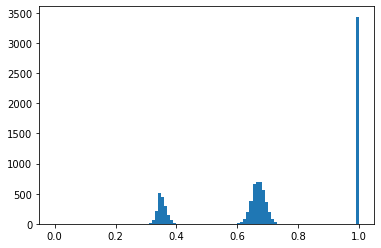

In [12]:
negatives = df_raw[df_raw.airline_sentiment == 'negative']
print('min:', negatives.negativereason_confidence.min(), 'max:', negatives.negativereason_confidence.max())
plt.hist(negatives.negativereason_confidence, bins=np.linspace(0,1,101));

In [13]:
low_confidence  = negatives[(0.2 < negatives.negativereason_confidence) & (negatives.negativereason_confidence < 0.5)]
med_confidence  = negatives[(0.5 < negatives.negativereason_confidence) & (negatives.negativereason_confidence < 0.8)]
high_confidence = negatives[(0.8 < negatives.negativereason_confidence)]
print('n_low_confidence: ', len(low_confidence), '\nn_med_confidence: ', len(med_confidence),
      '\nn_high_confidence:', len(high_confidence))
#for r in low_confidence.sample(n=20, random_state=42).iterrows(): print(r[1].negativereason, r[1].text)
#for r in med_confidence.sample(n=20, random_state=42).iterrows(): print(r[1].negativereason, r[1].text)
#for r in high_confidence.sample(n=20, random_state=42).iterrows(): print(r[1].negativereason, r[1].text)

n_low_confidence:  1781 
n_med_confidence:  3952 
n_high_confidence: 3445


Of a sample of 20 low confidence negative reasons, I think 2 are misclassified and 3 should not actually be negative. Of a sample of 20 medium confidence negative reasons, I think 2 mention more than one issue with one of the issues listed as the negative reason, otherwise I agree with the classifications. I agree with all of a sampled 20 high confidence negative reasons. It might be helpful to reduce importance of these rows to the training loss.

Now we can describe our negative reason classification task:
- This is a **10- or 11-way classification task**, with 10 categories plus 1 N/A class if we choose to include it.
- This is an unbalanced dataset, biased significantly towards the *N/A* and *Customer Service Issue* classes and against the *Damaged Luggage* and *longlines* classes.
- Our naive baseline model for the 10-way task always predicts *Customer Service Issue* with an accuracy of 31.71%.
- Our naive baseline model for the 11-way task always predicts *N/A* with an accuracy of 37.31%.

Next, let's take a look at the tweet text and identify what kinds of preprocessing might be helpful.  <a name="text" />

In [14]:
df_raw['text'].describe()

count              14640
unique             14427
top       @united thanks
freq                   6
Name: text, dtype: object

Good...all rows have tweet data. 213 rows contain duplicate text.

In [15]:
print(df_raw[df_raw['text'] == '@united thanks'][['airline_sentiment', 'airline_sentiment_confidence']])

     airline_sentiment  airline_sentiment_confidence
504           positive                        1.0000
515           positive                        0.6634
2285          positive                        0.6809
2859          positive                        1.0000
3565           neutral                        0.7168
3604          positive                        1.0000


Interesting...the most frequent text '@united thanks' receives different labels. This certainly reduces confidence in the accuracy of our labels. When we review how well our initial model performs, we should consider how robust our model is to noisy labels and consider whether it would be worth our time to remove or relabel some samples.

Let's examine the length of the tweets. We would expect a cap at 160 characters due to Twitter's character limit in 2015.

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text_len, dtype: float64


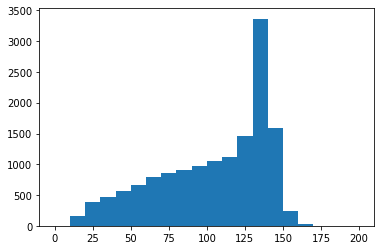

In [16]:
df_raw['text_len'] = df_raw.text.apply(len)
print(df_raw.text_len.describe())
plt.hist(df_raw.text.apply(len), bins=np.linspace(0, 200, 21));

Tweet length appears follow an interesting distribution - in particular, we can see a spike in texts around the 160 limit. This is an interesting feature that we should consider preserving - Twitter users who have more to say may, for instance, be feeling stronger sentiment compared to users who aren't interested in writing very much. Since our ULMFiT model is based on words, we'll be degrading this potential signal. Adding a field for original text length in characters would preserve this signal.

The shortest tweet is a reasonable 12 characters, however, some tweets appear to be exceeding Twitter's character limit. We should investigate this.

In [17]:
# change 165 to 160 or lower for more examples
for t in df_raw.text[df_raw.text_len > 165].iteritems(): print(t)

(8359, '@JetBlue Hey guys! Your Flight Booking Problems system ran my first and middle names together at time of Flight Booking Problems. Is that going to be a #TSAnightmare ?')
(10405, "@USAirways Eyyyy! Cancelled Flightlations, Flight Booking Problemss, reFlight Booking Problemss, but y'all got me on the same flight out tonight (not tomorrow) &amp; the FC upgrade. Thx!")
(11665, '@USAirways My Flight Booking Problems C68LD9 just times out when I select it under Manage My Flight Booking Problems for months now. I have emailed but no response. Help?')
(11783, "@USAirways Flight Booking Problems a flight using credit from a previously Cancelled Flightled flight. Can't get thru on the phone and can't book online. Help please.")
(11807, '@USAirways Travelling from pwm to atl on Sunday That flight got Cancelled Flightled and my new flight is Cancelled Flightled and got disconnected when reFlight Booking Problems')
(12208, "@AmericanAir When Flight Booking Problems an int'l flight online, d

Notably, all of these include negative reasons have similar spelling errors such as 'Cancelled Flighted', 'Cancelled Flightled', 'reFlight Booking Problems', 'Flight Booking Problems', 'Late Flightr'.

While I had no luck finding exact methods used to preprocess this dataset, one person in a [Kaggle discussion](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/discussion/18283) hypothesized that a find/replace operation was applied to particular strings in the tweets (e.g. 'late' -> 'Late Flight' and 'cancel' -> Cancelled Flight).

Let's look into this theory, by checking whether potentially replaced words exist in the text.

In [18]:
# negative reasons: ['Bad Flight', "Can't Tell", 'Late Flight', 'Customer Service Issue', 'Flight Booking Problems',
#                    'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight', 'Damaged Luggage', 'longlines']
for i, text in df_raw.text.iteritems():
    if 'late' in text: print(text)

For brevity, I haven't shown the full investigation, however it seems clear that the following replacements were made:
* 'cancel' -> 'Cancelled Flight'
* 'late' -> 'Late Flight'
* 'booking' -> 'Flight Booking Problems'

We could try undo-ing the find/replace operation, but we risk removing occurrences where the text was actually written as such. Let's leave this for now as a possibility to explore in the future.

During the course of the text investigation, there were a few more noteworthy observations:
* There is some HTML (e.g. \\& amp;) to be cleaned, but fastai takes care of this by default.
* Some tweets contain shortened URLs. Short of following the URLs and scraping them for additional data, they don't have any meaning beyond their existence in the tweet. By replacing the URL with a token 'xxurl', we could identify that the user went to the effort of adding a URL.

For ULMFiT classification, we only need the columns we've reviewed so far: the language inputs 'text' and the labels 'airline_sentiment' and/or 'negativereason'. However, we could also consider adding other columns as inputs and there aren't too many to explore, so let's look at them now, starting with the location data. <a name="tweet_coord" />

In [19]:
df_raw[['tweet_coord', 'tweet_location', 'user_timezone']].describe()

,tweet_coord,tweet_location,user_timezone
count,1019,9907,9820
unique,832,3081,85
top,"[0.0, 0.0]","Boston, MA",Eastern Time (US & Canada)
freq,164,157,3744


In [20]:
location_counts = df_raw.tweet_location.value_counts()
#location_counts[location_counts > 20]

Tweet coordinates are infrequently listed compared to tweet location and user timezone. Tweet location could reasonably be predictive on its own, as specific airports and general regions could both be reasonably predictive in both tasks (e.g maybe NYC has generally more delays and/or cancellations and/or grumpier travellers). However, it looks like this column contains bogus values as well as values with similar meanings but different spellings and would require some effort to clean.

Next let's check out the date and time columns. <a name="tweet_created" />

In [21]:
'min:', df_raw.tweet_created.min(), 'max:', df_raw.tweet_created.max(), df_raw.tweet_created.describe()

('min:',
 '2015-02-16 23:36:05 -0800',
 'max:',
 '2015-02-24 11:53:37 -0800',
 count                         14640
 unique                        14247
 top       2015-02-24 09:54:34 -0800
 freq                              5
 Name: tweet_created, dtype: object)

Here we see confirmation that the tweets were collected in a span of 1 week between Feb 16, 2015 and Feb 24, 2015.

In [22]:
timezone_freq = df_raw.user_timezone.fillna('Unknown').value_counts()
timezone_freq[timezone_freq > 20]

Unknown                        4820
Eastern Time (US & Canada)     3744
Central Time (US & Canada)     1931
Pacific Time (US & Canada)     1208
Quito                           738
Atlantic Time (Canada)          497
Mountain Time (US & Canada)     369
Arizona                         229
London                          195
Alaska                          108
Sydney                          107
Hawaii                          104
Amsterdam                        74
America/Chicago                  37
Indiana (East)                   26
America/New_York                 26
Paris                            25
Brasilia                         23
Abu Dhabi                        23
Name: user_timezone, dtype: int64

With only 1 week of data, we can ignore the date portion of the timestamp, however the time of day is more likely to be relevant. In particular, the combination of 'user_timezone', 'tweet_location', and 'tweet_created' could be useful for the model in detecting both sentiment and negative reason (e.g. 2am tweets might tend to be more negative and caused by delays).

Finally, let's take a look at retweet_count. <a name="retweet_count" />

In [23]:
retweet_count_freqs = df_raw.retweet_count.value_counts() 
print(df_raw.retweet_count.describe())
print('\nFrequency of counts:\n', retweet_count_freqs)

count    14640.000000
mean         0.082650
std          0.745778
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         44.000000
Name: retweet_count, dtype: float64

Frequency of counts:
 0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
9         1
31        1
18        1
15        1
28        1
44        1
11        1
Name: retweet_count, dtype: int64


There may be value in retweet counts, but could also be easy for the model to quickly memorize the training data for infrequently encountered tweet counts. A simple way to address this is to bin the counts (e.g. bins = 0, 1, 2, 3+).

#### Prepare Training, Validation, and Test Sets <a name="prepare-datasets"></a>

First, we'll preprocess the data according to our earlier analysis, starting with dropping unused columns:

In [24]:
df = df_raw.copy()
df.drop(columns=['tweet_id', 'airline', 'airline_sentiment_gold', 'name', 
                 'negativereason_gold', 'tweet_coord', 'tweet_location'], 
        inplace=True)
df.columns

Index(['airline_sentiment', 'airline_sentiment_confidence', 'negativereason',
       'negativereason_confidence', 'retweet_count', 'text', 'tweet_created',
       'user_timezone', 'text_len'],
      dtype='object')

Converting the 'tweet_created' to a datetime object:

In [25]:
df.tweet_created = pd.to_datetime(df.tweet_created, infer_datetime_format=True)
print(df.tweet_created.dtype)

datetime64[ns, pytz.FixedOffset(-480)]


Mapping non-standard timezones to standard timezones for all values of 'user_timezone' with 20 or more occurrences; then finding the local date and time:

In [26]:
tz_conversions = {'Eastern Time (US & Canada)': 'US/Eastern', 'Central Time (US & Canada)': 'US/Central',
    'Pacific Time (US & Canada)': 'US/Pacific', 'Quito': 'Etc/GMT-5', 'Atlantic Time (Canada)': 'Canada/Atlantic',
    'Mountain Time (US & Canada)': 'US/Mountain', 'Arizona': 'US/Arizona', 'London': 'Europe/London',
    'Alaska': 'US/Alaska', 'Sydney': 'Australia/Sydney', 'Hawaii': 'US/Hawaii', 'Amsterdam': 'Europe/Amsterdam',
    'Indiana (East)': 'US/East-Indiana', 'Paris': 'Europe/Paris', 'Abu Dhabi': 'Etc/GMT+4', 'Brasilia': 'Etc/GMT-3'}

def toLocalTime(dt, tz, nonstd_tz_map=None):
    """Convert a date, `dt`, to the local time at timezone, `tz`, optionally correcting ."""
    if tz in pytz.all_timezones: std_tz = tz
    elif nonstd_tz_map and tz in nonstd_tz_map: std_tz = nonstd_tz_map[tz]
    else: return None
    return dt.astimezone(std_tz)

local_dt = df.apply(lambda row: toLocalTime(row.tweet_created, row.user_timezone, tz_conversions), axis=1)

Creating new hour column from the local datetime and dropping the remaining datetime columns:

In [27]:
def extractHour(dt): 
    if hasattr(dt, 'hour'): return dt.hour

df['tweet_createdLocalHour'] = 'xxtweet_createdLocalHour_' + (local_dt.apply(extractHour)).astype(str)
df.head(2)

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,retweet_count,text,tweet_created,user_timezone,text_len,tweet_createdLocalHour
0,neutral,1.0000,NaN,NaN,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,Eastern Time (US & Canada),35,xxtweet_createdLocalHour_14.0
1,positive,0.3486,NaN,0.0,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,Pacific Time (US & Canada),72,xxtweet_createdLocalHour_11.0


Binning 'retweet_count' into buckets: 0, 1, 2, and 3+, and 'text_len' into buckets: <75, 75to130, >130.

In [28]:
tl_int = df.text_len.copy()
df.loc[:, 'text_len'] = df.text_len.astype(str)
df.loc[tl_int <= 75, 'text_len'] = '<=75'
df.loc[(tl_int > 75) & (tl_int < 130), 'text_len'] = '75_130'
df.loc[tl_int >= 130, 'text_len'] = '>130'
df.loc[:, 'text_len'] = 'xxtextlencount_' + df.text_len
df.text_len.value_counts()

xxtextlencount_75_130    5862
xxtextlencount_>130      5241
xxtextlencount_<=75      3537
Name: text_len, dtype: int64

In [29]:
df.loc[:, 'retweet_count'] = df.retweet_count.astype(str)
df.loc[df.retweet_count.astype(np.int64) >= 3, 'retweet_count'] = '3+'
df.loc[:, 'retweet_count'] = 'xxretweetcount_' + df.retweet_count
df.retweet_count.value_counts()

xxretweetcount_0     13873
xxretweetcount_1       640
xxretweetcount_2        66
xxretweetcount_3+       61
Name: retweet_count, dtype: int64

#### Create test set

To create the test set, we pull out 7% of the original data, randomly sampled, to create a test dataset of 1024 samples. This leaves 13616 tweets for training and validation. 7% split was chosen so that our test accuracy will have ~3 digits of precision (`3.01 = log10(1024)`, note: this is a very rough approximation). We'll create a similarly-sized validation set. This sample size would not be a good choice if we cared about small changes in prediction accuracy. However, it is sufficient for broadly determining the ability of a ULMFiT model to fit the data and to compare the model with others.

It is important to mention that the test set is created from a sample of the full dataset, before removing any rows, regardless of labelling accuracy. This ensures that our test set best represents the real data distribution and does not overestimate our model's performance. Given a more specific goal, we should revisit this decision to ensure that the test set best represents the data distribution of the goal task.

Thus far, we have considered modeling both sentiment and negative reason classification. From here on we'll focus on modeling sentiment only. The process for modelling negative reason would be similar.

In [30]:
test_pct = 0.07

# get random indices for our train and test sets
np.random.seed(9741) # set seed to ensure we always get the same test set
random_idx = np.random.permutation(len(df))
n_test = int(len(df) * test_pct)
train_idx = random_idx[:-n_test]
test_idx = random_idx[-n_test:]

# split train and test sets
df_train = df.iloc[train_idx].copy()
df_test = df.iloc[test_idx].copy()

print('n_train:', len(df_train))
print('n_test:', len(df_test))

n_train: 13616
n_test: 1024


#### Mark validation set

To create the validation set, we'll add a new column to the training dataframe for identifying these rows.

In [31]:
valid_pct = 0.2

n_valid = int(valid_pct * len(df_train))

# get random indices for our validation set
np.random.seed(8874) # make sure we always get the same random values
valid_idx = np.array([0] * (len(df_train) - n_valid) + [1] * n_valid)
valid_idx = np.random.permutation(valid_idx)
df_train['is_valid'] = valid_idx

#### Finalize training set

We'll remove rows which have low confidence labels from our training set and drop columns not used in sentiment classification. Note that we don't remove these rows from our test set as this would not reflect the real data and might lead to unrealistic expectations.

In [32]:
df_train = df_train[df_train.airline_sentiment_confidence > 0.5]
df_train = df_train[cols + ['is_valid']]

df_test = df_test[cols]

One final look at the data to make sure we didn't make any obvious mistakes:

In [33]:
print('Sentiment classification - training set:', len(df_train))
df_train.head(2)

Sentiment classification - training set: 13392


,airline_sentiment,text_len,retweet_count,tweet_createdLocalHour,text,is_valid
5101,negative,xxtextlencount_>130,xxretweetcount_0,xxtweet_createdLocalHour_nan,@SouthwestAir How to find out if my parents lu...,0
12352,negative,xxtextlencount_>130,xxretweetcount_0,xxtweet_createdLocalHour_7.0,@AmericanAir don't merge with an airline that ...,0


In [34]:
print('Sentiment classification - test set:', len(df_test))
df_train.head(2)

Sentiment classification - test set: 1024


,airline_sentiment,text_len,retweet_count,tweet_createdLocalHour,text,is_valid
5101,negative,xxtextlencount_>130,xxretweetcount_0,xxtweet_createdLocalHour_nan,@SouthwestAir How to find out if my parents lu...,0
12352,negative,xxtextlencount_>130,xxretweetcount_0,xxtweet_createdLocalHour_7.0,@AmericanAir don't merge with an airline that ...,0


#### Save prepared datasets

Save our work so that we can skip this preprocessing step when we return to this notebook later.

As a convenience, we'll also prepare a data set which combines the training and test sets for training the language model in the next step.

In [35]:
def save_df(df, filepath):
    filepath.parent.mkdir(exist_ok=True)
    df.to_csv(filepath, header=True, index=False)

df_train_and_test = pd.concat([df_train.loc[:, cols], df_test])
print('both:', len(df_train_and_test), 'train:', len(df_train), 'test:', len(df_test))

save_df(df_train_and_test, path / 'train_and_test.csv')
save_df(df_train, path / 'train.csv')
save_df(df_test, path / 'test.csv')

both: 14416 train: 13392 test: 1024


## 2. Language Model Fine-Tuning <a name="2"></a>
<a name="0">[(... back to the top)](#top)</a> 

### Prepare language model data
Since we aren't using our classification labels, we can use all of our data in this step, not just the training data. However, we do still need a validation set so we can tune our model. We create this by randomly sampling 10% of the original data (~1500 rows).

This text processing step can take some time, so we save the language model data to disk for easy retrieval in the future.

In [2]:
data_lm = (TextList.from_csv(path, 'train_and_test.csv', cols=model_input_cols) # load data
                   .split_by_rand_pct(0.1)    # create validation set from 10% of rows
                   .label_for_lm()            # add dummy labels (labels are ignored by the language model)
                   .databunch())              # prepare the data for use in fastai models
data_lm.save('data_lm.pkl')

For quickly reloading the data:

In [3]:
data_lm = load_data(path, 'data_lm.pkl')

#### Load preprocessed language model data:
Let's take a look at the first few rows of a batch of data to verify the data has loaded as expected:

In [4]:
data_lm.show_batch()

idx,text
0,xxretweetcount_0 xxtweet_createdlocalhour_23.0 @usairways i have a story for you . xxmaj it starts with a two hour delayed flight that makes me miss my connection in xxmaj miami . xxbos xxtextlencount_75_130 xxretweetcount_0 xxtweet_createdlocalhour_15.0 @usairways xxmaj what 's the seat assignment policy ? xxmaj why let us choose a seat only to change it on us two weeks xxmaj late xxmaj flightr ? xxbos xxtextlencount_<=75 xxretweetcount_0 xxtweet_createdlocalhour_nan @americanair 11 out of
1,"travel way too much for you to tell me coffee is not a basic option xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_18.0 @americanair xxmaj next xxmaj friday , i 'll take xxup xxunk to xxunk morning , xxunk i have to take my bags at xxup lga or i get them to my final dest ? xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_nan @americanair attached original ticket . flight number was xxunk . is n't the"
2,wo n't waive change fee for flights i had to xxmaj cancelled xxmaj flight due to east coast storms . xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_nan @usairways \n xxmaj this is how vacations get xxmaj cancelled xxmaj flightled been on hold xxunk 40 + minutes still have nt talked to anyone . # failure http : / / t.co / xxunk xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_18.0 @jetblue if u want to be
3,"@united 3 hours to rebook but 8 hours xxunk the same problem again . xxmaj arrive at gate stopped cause now infant is sitting in 4 yr old lap xxbos xxtextlencount_<=75 xxretweetcount_0 xxtweet_createdlocalhour_10.0 @americanair i need an answer why we ca n't get into xxmaj wichita xxmaj falls . xxbos xxtextlencount_75_130 xxretweetcount_0 xxtweet_createdlocalhour_18.0 @southwestair xxunk , gate said they 're holding connections . xxmaj thanks for quick response ! xxbos"
4,"on . xxmaj but i wo n't be for days ! xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_16.0 @americanair agents refuse to help , "" too busy "" & & need to call advantage # . xxup no xxup one willing to help and apparently being exec plat means xxup zero xxbos xxtextlencount_75_130 xxretweetcount_0 xxtweet_createdlocalhour_8.0 @united i need a xxunk of what the "" international xxunk "" on my flights cover . xxmaj"


Here it is worth noting that the `fastai` library does some text preprocessing automatically for us. There are 4 text preprocessing steps:
1. Preprocessing Transforms - list of functions that modify sentences (see next cell)
2. Tokenization - [Spacy](https://spacy.io/) is the default tokenizer, and does some smart word processing (e.g. replacing "haven't" with "have n't" and "it's" with "it 's").
3. Postprocessing Transforms - list of functions that modify words/tokens (see next cell)
4. Numericalization - Words/tokens are replaced by numbers for indexing into the embedding layer. Words with < N occurrences are replaced by the token *xxunk*, where N defaults to 2.

Here are the fastai methods being run for data processing and the list special tokens used. See the method source (Shift+Tab 3 times in Jupyter notebook) or the [fastai docs](https://docs.fast.ai/text.transform.html#text.transform) for more info.

In [5]:
print('Preprocessing transforms :', [f.__name__ for f in defaults.text_pre_rules])
print('Postprocessing transforms:', [f.__name__ for f in defaults.text_post_rules])
print('Special Tokens           :', defaults.text_spec_tok)

Preprocessing transforms : ['fix_html', 'replace_rep', 'replace_wrep', 'spec_add_spaces', 'rm_useless_spaces']
Postprocessing transforms: ['replace_all_caps', 'deal_caps']
Special Tokens           : ['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']


### Prepare language model learner
Our first goal is to generate fine-tuned word embeddings for the vocabulary in our Tweets data from embeddings trained on a large, general English language dataset.

Since a language model predicts the next token in a sentence, it captures useful information about how words are used and have been shown to be useful in pretraining a model for common NLP tasks. This model is uses the [AWD LSTM](https://github.com/salesforce/awd-lstm-lm) architecture pretrained on WikiText-103.

In this case, tokens are all words in our vocabulary as well as any special tokens. For example, 'xxbos' is added to the beginning of every sample and 'xxunk' replaces all words that aren't in our vocabulary. The full list of special tokens is in the cell output above.

The fastai library merges our vocabulary with the vocab used in used in Wikitext-103 so that the pretrained embeddings are preserved and our new words initialized to the mean of all pretrained embeddings.

Here we set the remaining hyperparameters of our language model.
* arch = AWD_LSTM : AWD_LSTM and Transformer are the two options for which the fastai library includes pretrained weights. In trials not shown, the Transformer architecture takes quite a lot more memory and computational power to train, so we'll stick with AWD_LSTM.
* bs = 400        : Larger batch sizes speed up learning, so it is set to approximately the largest batch size that will fit on the GPU (I set this by trial and error).
* drop_mult = 1.0 : Each architecture has its own default values for dropout. `drop_mult` allows us to scale all of the individual dropouts by a constant factor. This is the first hyperparameter for directly controlling the balance between overfitting and underfitting within a particular architecture.

Additionally, there are several default hyperparameters. Except for `bptt`, we must keep these unchanged to easily take advantage of the pretrained weights. Increasing `bptt` increases the ability for the model to learn long term dependencies - in this case, the default value `bptt=70` is fine for now.
* bptt = 70    : number of iterations to calculate back-propagation through time
* emb_sz = 400 : size of the embedding weights
* nh = 1150    : number of hidden units
* nl = 3       : number of hidden layers

In [6]:
arch = AWD_LSTM # AWD_LSTM, Transformer, or TransformerXL (no pretrained weights)
bs = {'AWD_LSTM': 400, 'Transformer': 40}[arch.__name__]
drop_mult = 1.0 # default is 1.0
lm_data_name = 'data_lm.pkl'
lm_trial_prefix = 'lm_' + arch.__name__ + '_drop_mult_' + str(drop_mult) + '_'

data_lm = load_data(path, lm_data_name, bs=bs)
lm_learn = language_model_learner(data_lm, arch=arch, drop_mult=drop_mult)
print('Loaded language model using data:', lm_data_name, '\nTrial prefix:', lm_trial_prefix)

Loaded language model using data: data_lm.pkl 
Trial prefix: lm_AWD_LSTM_drop_mult_1.0_


In [7]:
lm_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


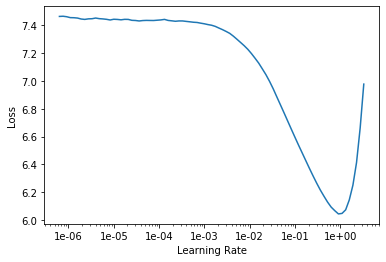

In [8]:
lm_learn.recorder.plot()

The learning rate finder `lr_find` finds the training loss for a wide range of learning rates. From this plot, we choose a learning rate that where the loss is still decreasing. This has two key advantages: 1) it reduces training time and 2) it minimizes the number of times the model sees any particular example, which is a form of regularization, helping to keep the model from being able to memorize the training set.

In [9]:
lr = 0.1
lm_learn.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,time
0,5.409210,3.819160,0.276911,00:05
1,4.559108,3.690468,0.291429,00:05


In [10]:
lm_learn.save(lm_trial_prefix + 'fit_head')

So far, we have only changed the weights in the last layer of the model. Now we'll unfreeze the model and allow all weights to be updated.

In [11]:
lm_learn.load(lm_trial_prefix + 'fit_head');
lm_learn.unfreeze()

In [12]:
lm_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


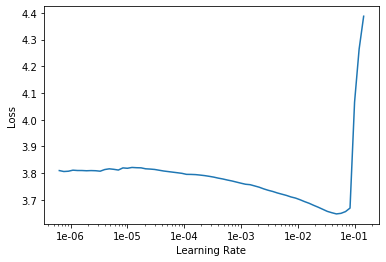

In [13]:
lm_learn.recorder.plot(skip_end=15)

As before, we choose a learning rate as large as possible while still avoiding the catastrophic forgetting 'cliff'. This point is just before the steep increase in loss, which occurrs here at approximately `lr=0.6`).

Note that if we get too close to the 'cliff', we'll see our loss and accuracy metrics start getting significantly worse. If this happens, resume from a previously saved model and try a lower learning rate.

In [14]:
lr = 0.01
lm_learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.672147,3.545262,0.295929,00:06
1,3.552445,3.410305,0.321089,00:06
2,3.423444,3.376176,0.326089,00:06
3,3.302068,3.363415,0.329500,00:06


Notice in epoch 4 that the training loss drops below the validation loss which means we are beginning to overfit. By adjusting the dropout with the `drop_mult` parameter during model initialization, we can directly trade-off our model's tendency to overfit with our model's capacity to learn.

In [15]:
lm_learn.save(lm_trial_prefix + 'fine_tuned')
lm_learn.save_encoder(lm_trial_prefix + 'fine_tuned_enc')

Fitting for more cycles may improve our model further, although the model may also begin overfitting.

In [16]:
lm_learn.load(lm_trial_prefix + 'fine_tuned');

In [17]:
lm_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


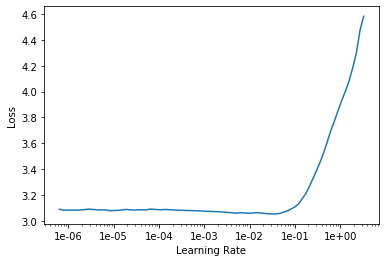

In [18]:
lm_learn.recorder.plot()

Let's try backing away from the "catastrophic forgetting cliff" a bit more to see if we can continue improving the accuracy of our model's predictions.

In [19]:
lr = 4e-3
lm_learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.052228,3.348237,0.333661,00:06
1,3.017553,3.349161,0.334339,00:06
2,2.958324,3.347079,0.335054,00:06
3,2.902127,3.357914,0.335804,00:06


We've improved accuracy and validation loss at the cost of a small amount of overfitting. Not shown, I tried continuing training a bit more, however the validation loss began to increase while the accuracy remained about the same. Let's save this model and move on to classification.

In [20]:
lm_learn.save(lm_trial_prefix + 'fine_tuned_2')
lm_learn.save_encoder(lm_trial_prefix + 'fine_tuned_enc_2')

## 3. Classification Model <a name="3"></a>
<a name="0">[(... back to the top)](#top)</a> 

### Prepare Classification Model Data
Here, we create the data bunch using the training and test datasets we prepared in step 1. There are a couple of things worth noting here:
* We must explicitly pass in the same language model vocabulary so that the classification model will correctly use the language model embeddings.
* We create a validation set by randomly selecting 20% percent of the training set. So now our training set has 12527 samples, and our validation set has 1089 samples. This gives us roughly 3 digits of precision in our validation set.

In [2]:
lm_data_fn = 'data_lm.pkl'
train_fn = 'train.csv'
test_fn = 'test.csv'
clas_data_fn = 'data_clas.pkl'

#### Load datasets:

Get the same vocabulary we used in the language model.

In [3]:
vocab = load_data(path, lm_data_fn).vocab

Load training and test datasets. Split validation from training dataset.

In [4]:
df_train = pd.read_csv(path / 'train.csv')
df_test  = pd.read_csv(path / 'test.csv')

df_valid = df_train.loc[df_train.is_valid == 1, cols]
df_train = df_train.loc[df_train.is_valid == 0, cols]

print('train:', len(df_train), 'valid:', len(df_valid), 'test:', len(df_test))
df_train.head(2)

train: 10724 valid: 2668 test: 1024


,airline_sentiment,text_len,retweet_count,tweet_createdLocalHour,text
0,negative,xxtextlencount_>130,xxretweetcount_0,xxtweet_createdLocalHour_nan,@SouthwestAir How to find out if my parents lu...
1,negative,xxtextlencount_>130,xxretweetcount_0,xxtweet_createdLocalHour_7.0,@AmericanAir don't merge with an airline that ...


Create the classification model data object.

In [5]:
data_clas = TextClasDataBunch.from_df(path, df_train, df_valid, df_test, vocab=vocab, label_cols=0, text_cols=model_input_cols)
data_clas.save(clas_data_fn)

In [6]:
data_clas.show_batch()

text,target
xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_nan @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos xxtextlencount_>130 xxretweetcount_1 xxtweet_createdlocalhour_nan @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # xxunk # xxunk # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 xxunk 🎀 http : / / t.co / xxunk,neutral
"xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_20.0 @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
"xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_12.0 @jetblue i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",negative
xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_12.0 @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over ! ! !,negative


### Prepare Classification Model Learner
The goal of the classification model is to predict the class (sentiment = {*negative*, *neutral*, *positive*}) from a series of word embeddings which we've transferred from our language model.

The primary difference between this model and the languange model is that we now predict a class rather than the next word. This can be seen by inspecting the final layer, which now has only 3 outputs (one per class) followed by a softmax activation. The model's prediction is the class with the largest value. Another important difference between the language model and the classification model is in the default levels of dropout in each section of the model. These defaults are tuned by the creators of fastai for generally performing well on classification tasks.

As before, we have a variety of hyperparameters to set, and the justifications for each are the similar to the language model so I won't go through these again with the exception of `drop_mult`. I found that reducing the dropout multiplier from 1.0 to 0.7 both reduced the validation loss and increased the accuracy metric.

In [2]:
arch = AWD_LSTM # AWD_LSTM, Transformer, or TransformerXL
bs = {'AWD_LSTM': 512, 'Transformer': 32}[arch.__name__]
drop_mult = 0.7
lm_encoder_name = 'lm_AWD_LSTM_drop_mult_1.0_fine_tuned_enc_2'
clas_data_name = 'data_clas.pkl'
clas_trial_prefix = 'clas_' + arch.__name__ + '_drop_mult_' + str(drop_mult) + '_'

Here we reload the saved data and create the learner. Note how we intentionally set the language model encoder to the same encoder we just fine-tuned in the previous step. This is transfer learning!

In [3]:
data_clas = load_data(path, clas_data_name, bs=bs)
learn = text_classifier_learner(data_clas, arch, drop_mult=drop_mult)
learn.load_encoder(lm_encoder_name) # <-- transfer learning!
print('Loaded classification model using data:', clas_data_name, '\nTrial prefix:', clas_trial_prefix)

Loaded classification model using data: data_clas.pkl 
Trial prefix: clas_AWD_LSTM_drop_mult_0.7_


As we did with the language model, we find a good learning rate and then we train our model. In this case, we'll first train with all but last layer group of weights frozen. Then we'll unfreeze weights one layer group at a time until we're training the whole model.

In [4]:
learn.freeze()

In [5]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


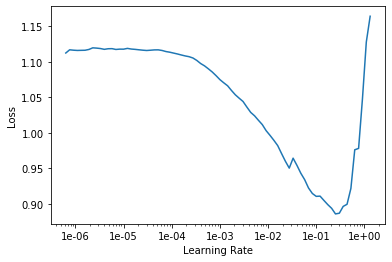

In [6]:
learn.recorder.plot(skip_start=10, skip_end=5)

There is currently an issue with dataloaders in PyTorch, on which fastai is based, which causes them to run very slowly on Windows - this is why my training times are very slow. This should not be an issue on a Linux machine. For reference, [here](https://github.com/pytorch/pytorch/issues/12831) is the issue on GitHub.

In [7]:
lr = 0.1
learn.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.689919,0.792782,0.688156,01:06
1,0.670333,0.551991,0.787481,01:06


In [8]:
learn.save(clas_trial_prefix + 'first')

In [4]:
learn.load(clas_trial_prefix + 'first');
learn.freeze_to(-2)

In [5]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


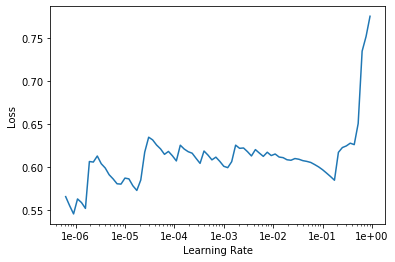

In [6]:
learn.recorder.plot(skip_end=4)

Since we're training multiple layer groups, we can use a technique fastai calls "differential learning rates". This means that layer groups learn at different rates. Training seems to improve when earlier layer groups update slower than later groups. Over the past couple of years, fastai has used a variety of multipliers for reducing the learning rate (I've noticed 2x, 3x, 10x, and 45x). This is another hyperparameter which could be tuned, but I will stick with the latest default of 2x according to fastai's text model tutorial [here](https://docs.fast.ai/text.html).

In [7]:
lr = 1e-2
lr_reduction_factor = 2.
learn.fit_one_cycle(4, slice(lr/lr_reduction_factor, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.612556,0.474705,0.811844,01:07
1,0.581956,0.466378,0.802849,01:06
2,0.566736,0.443898,0.825712,01:07
3,0.531691,0.432114,0.838831,01:06


In [8]:
learn.save(clas_trial_prefix + 'second')

In [9]:
learn.load(clas_trial_prefix + 'second');
learn.freeze_to(-3)

C:\Users\David\Anaconda3\envs\fastai-py37_1\lib\site-packages\fastai\basic_train.py:326: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


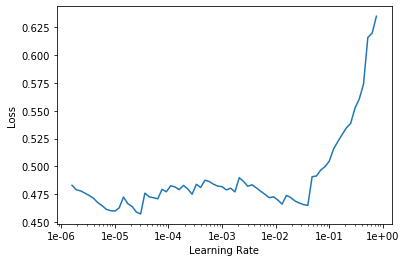

In [11]:
learn.recorder.plot(skip_start=15, skip_end=4)

In [12]:
lr = 1e-2
lr_reduction_factor = 2.
learn.fit_one_cycle(4, slice(lr/lr_reduction_factor,lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.490961,0.467503,0.826837,01:08
1,0.457514,0.473808,0.835832,01:08
2,0.405997,0.429537,0.842204,01:08
3,0.350965,0.440381,0.850075,01:08


Notice here that we're starting to overfit - as with the language model, this is okay so long as our validation loss and accuracy metric both continue to improve.

In [13]:
learn.save(clas_trial_prefix + 'third')

In [14]:
learn.load(clas_trial_prefix + 'third');

In [15]:
lr = 1e-3
lr_reduction_factor = 2.
learn.fit_one_cycle(4, slice(lr/lr_reduction_factor,lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.258947,0.439739,0.850075,01:08
1,0.249648,0.454287,0.847451,01:08
2,0.234214,0.457502,0.846702,01:09
3,0.220239,0.455409,0.849325,01:08


As we continue training, we see the training loss continue to drop, but the validation loss and accuracy are no longer improving, in fact they're starting to get a bit worse. 

This is a good time to export our our best model and begin our analysis.

In [16]:
learn.load(clas_trial_prefix + 'third');
learn.export('clas_initial_model.pkl')

## 4. Analysis, Discussion, and Next Steps <a name="4"></a>
<a name="0">[(... back to the top)](#top)</a> 

Now let's analyze our performance on the validation set. Note that the `TextClassificationInterpretation` class we're using currently only works for the AWD_LSTM model.

Let's load our initial classification model.

In [59]:
clas_data_fn = 'data_clas.pkl'
model_fn = 'clas_initial_model.pkl'
bs = 512

data = load_data(path, clas_data_fn, bs=bs)
learn = load_learner(path, model_fn)
learn.data = data_clas

First, let's take a look at a few tweets that I made up to check that the predictions make sense.

In [ ]:
learn.predict("Thanks for everything!")

In [ ]:
learn.predict("flying to #mco to visit my family")

In [ ]:
learn.predict("I didn't like the flight at all")

These are all correct, which is promising.

Next, let's get the model's predictions on the validation set.

In [85]:
ds_type = DatasetType.Valid

preds = learn.get_preds(ds_type=ds_type, with_loss=True, ordered=True)
# ^ note: when using `with_loss`, must set `ordered=True` or the losses will not correspond to the correct prediction
print('predictions, targets, and losses:')
[p.size() for p in preds]

predictions, targets, and losses:


[torch.Size([2668, 3]), torch.Size([2668]), torch.Size([2668])]

The `TextClassificationInterpretation` class has some basic convenience functions for interpreting the model.

In [86]:
interp = TextClassificationInterpretation(learn, *preds)

We can recall from training that our final accuracy was ***.

Our validation loss and accuracy metrics are useful as single numbers to improve on, but let's now explore how well we did at predicting each class.

A more detailed way to characterize the model's performance is by using a confusion matrix. A confusion matrix compares predictions with their actual labels, each square corresponds to the number of examples in each bucket. Correct predictions are along the diagonal.

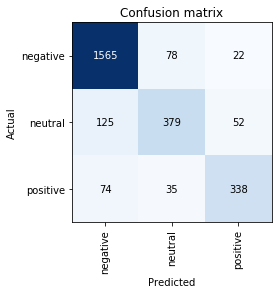

In [87]:
interp.plot_confusion_matrix()

Here we see that the model has the toughest time distinguishing between negative and neutral texts. Additionally, we noted during data exporation that we might have to account for the fact that the negative class several times more examples than the other 2 classes. It appears that this is not an issue. In fact, as a percentage of the total, there are far more neutral examples misclassified than either of the other 2 classes.

Next let's look at the top 5 validation losses:

In [88]:
interp.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
xxbos xxtextlencount_75_130 xxretweetcount_0 xxtweet_createdlocalhour_12.0 @americanair - keeping xxup aa up in the xxmaj air ! xxmaj my crew chief cousin xxmaj alex xxmaj xxunk in xxup dfw ! http : / / t.co / xxunk,positive,neutral,7.70,0.00
"xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_16.0 @southwestair xxmaj what can we do to bring you back to xxmaj xxunk , xxup xxunk ? ! xxmaj we miss you terribly around here . xxmaj these other airlines are horrible ! !",negative,positive,7.32,0.00
xxbos xxtextlencount_>130 xxretweetcount_0 xxtweet_createdlocalhour_7.0 @southwestair - xxmaj we left ipad in a seat pocket . xxmaj filed lost item report . xxmaj received it exactly 1 week xxmaj late xxmaj flightr . xxmaj is that a record ? # unbelievable,negative,positive,6.64,0.00
xxbos xxtextlencount_75_130 xxretweetcount_0 xxtweet_createdlocalhour_11.0 @usairways and now you ca n't even accommodate us by letting us fly in to another airport ? ! xxmaj horrible service for your fault ! ! !,negative,neutral,6.25,0.00
"xxbos xxtextlencount_75_130 xxretweetcount_0 xxtweet_createdlocalhour_16.0 @southwestair i 'm excited too , but perhaps you could scale your xxunk back by a few weeks ...",negative,positive,6.23,0.00


Reading through these, it seems reasonable that these are some of the toughest examples to predict as several of these initially seem to be one class, but on finishing reading the example, a different class. And actually I think example *** 4 here is mislabled.

### Discussion

Where to go from here depends on both our goal and our constraints. We started with the fairly open-ended goal of applying the ULMFiT modeling process to the Twitter US Airlines Sentiment data. 

By clarifying the goal(s) and operational constraints, we could make a clearer decision on which steps to take next. Here are a 2 possibilities:
* Goal: maximize the accuracy (or related metric)
  * To achieve academic performance, we could take steps mentioned above to 
* Goal: deploy the model
  * Some likely constraints: max inference time threshold, min accuracy threshold

If we decided that our model needed further improvements, then the next step would be to manually review a sample our validation losses and sort them according to what kinds of errors the model seems to be making. This should help us determine where the model has the most room for improvement. Then, by estimating how much effort addressing a particular issue would be to improve, we could make the best use of our time in getting better results.

One weakness of this model is the loss of natural ordering of numbers. Since all inputs are treated as tokens, we binned variables such as 'text_len' and 'retweet_count' to preserve some meaning without creating a lot of extra tokens. It would be better to concatenate these features to the model, treating them as numbers. Sticking with the fastai library, it would be straightforward to implement this as a callback.

Since this is as far as I'll be taking this analysis in this notebook, let's take a look at the test accuracy to see how well this model performs on the test set.